<a href="https://colab.research.google.com/github/TomAmster/Data-Science/blob/master/Model_Error_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394148 sha256=9dce4a33cc7205ab73b86144d5a173811a6291f6c7afd78c9f6bc46a38d70e2e
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, cross_validate
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as AdaB
from imblearn.over_sampling import RandomOverSampler as ROS
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap
from sklearn.neighbors import NearestNeighbors

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
drive_dir = '/content/drive/Shared drives/DS Workshop/data/'
x_train_path = drive_dir + 'x_train_with_features'
X = pd.read_csv(x_train_path)

In [0]:
X.head()

,Unnamed: 0,bidder_id,outcome,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
0,0,e8e4603ed284adbd252a7a601f9bffe09oq6f,0.0,False,0,1,0,0,8,1,1,4,4,7,3,8.000000,2.000000,2.666667,2.000000,1.142857,0.111111,1,0.285714,1,1.000000,1,1.0,1,0.333333,4.0,4.000000,4.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.000000,5.263158e+07,4.494737e+12,52631579.0,4.494737e+12,0.0,0.0,1.0,0.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,1.000000,38308.0,47885.0,31923.0,5065.0,5065.0,7.0,25.000000,37.500000,0.000000,37.500000
1,1,fdd836950d203286832a21b930b9f6b58ch7s,0.0,False,1,0,0,1,456,135,1,119,26,292,140,3.377778,3.831933,3.257143,17.538462,1.256198,0.241265,1,0.417808,1,0.991597,1,1.0,1,0.007143,1.0,1.059259,3.0,0.0,0.00,0.003145,0.0,0.0,0.0,0.0,0.0,...,0.0,1,95.0,169.0,0.370614,1.850974e+12,2.041296e+13,52631579.0,5.025026e+13,169.0,53.0,14.0,14.0,23.0,10.0,13.0,13.0,52.0,94.0,1.0,0.0,0.0,1.0,0.0,0.0,11.0,17.0,18.0,7.0,1.837500,4511.0,2404.0,2320.0,6.0,1.0,1.0,18.201754,45.833333,19.517544,16.447368
2,2,69333c66e55cdd6cabcc6ae64531fc33w20n4,0.0,False,0,1,0,0,2,2,1,1,1,1,1,1.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0,0.000000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,947368421.0,9.473684e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
3,3,31a301c70e897bf36276031abdf07ab6cs6z0,0.0,False,0,1,0,0,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0,0.000000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,789473684.0,5.696500e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
4,4,50791a0a98478b7f78f8d30acaa4683dxab5p,0.0,False,0,1,0,1,695,130,1,196,50,546,291,5.346154,3.545918,2.388316,13.900000,1.210801,0.292981,1,0.307692,1,0.969388,1,1.0,1,0.003436,1.0,1.253846,25.0,0.0,0.06,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,189.0,196.0,0.282014,1.188183e+13,2.266448e+13,52631579.0,5.006458e+13,196.0,151.0,2.0,2.0,4.0,4.0,9.0,1.0,137.0,189.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,10.0,14.0,3.0,1.138889,2069.0,1376.0,1313.0,1.0,1.0,1.0,29.208633,35.683453,16.258993,18.848921


# Running models

In [0]:
#drop bidders with 1 bid or less

bots = X[X['outcome'] == 1]
ind = bots[bots['bids_count'] <= 1].index
X.drop(labels=ind, axis=0, inplace=True)

In [0]:
X.shape

(2008, 266)

In [0]:
Y = X['outcome']
X.drop(labels=['outcome', 'bidder_id', 'Unnamed: 0'], axis=1, inplace=True)
X.head()

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
0,False,0,1,0,0,8,1,1,4,4,7,3,8.000000,2.000000,2.666667,2.000000,1.142857,0.111111,1,0.285714,1,1.000000,1,1.0,1,0.333333,4.0,4.000000,4.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0,1.0,0.0,0.000000,5.263158e+07,4.494737e+12,52631579.0,4.494737e+12,0.0,0.0,1.0,0.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,1.000000,38308.0,47885.0,31923.0,5065.0,5065.0,7.0,25.000000,37.500000,0.000000,37.500000
1,False,1,0,0,1,456,135,1,119,26,292,140,3.377778,3.831933,3.257143,17.538462,1.256198,0.241265,1,0.417808,1,0.991597,1,1.0,1,0.007143,1.0,1.059259,3.0,0.0,0.00,0.003145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,1,95.0,169.0,0.370614,1.850974e+12,2.041296e+13,52631579.0,5.025026e+13,169.0,53.0,14.0,14.0,23.0,10.0,13.0,13.0,52.0,94.0,1.0,0.0,0.0,1.0,0.0,0.0,11.0,17.0,18.0,7.0,1.837500,4511.0,2404.0,2320.0,6.0,1.0,1.0,18.201754,45.833333,19.517544,16.447368
2,False,0,1,0,0,2,2,1,1,1,1,1,1.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0,0.000000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,947368421.0,9.473684e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
3,False,0,1,0,0,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0,0.000000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,789473684.0,5.696500e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
4,False,0,1,0,1,695,130,1,196,50,546,291,5.346154,3.545918,2.388316,13.900000,1.210801,0.292981,1,0.307692,1,0.969388,1,1.0,1,0.003436,1.0,1.253846,25.0,0.0,0.06,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0025,...,0.0,0,189.0,196.0,0.282014,1.188183e+13,2.266448e+13,52631579.0,5.006458e+13,196.0,151.0,2.0,2.0,4.0,4.0,9.0,1.0,137.0,189.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,10.0,14.0,3.0,1.138889,2069.0,1376.0,1313.0,1.0,1.0,1.0,29.208633,35.683453,16.258993,18.848921


In [0]:
#some time related columns are still in arbitrary units, lets transform them to seconds to avoid large values
X['global_max_time_diff'] = X['global_max_time_diff'] / 52631375.8934375
X['avg_max_time_diff'] = X['avg_max_time_diff'] / 52631375.8934375
X['avg_min_time_diff'] = X['avg_min_time_diff'] / 52631375.8934375
X['global_min_time_diff'] = X['global_min_time_diff'] / 52631375.8934375

In [0]:
#split to train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=4)

In [0]:
x_train.shape

(1506, 263)

In [0]:
x_test.shape

(502, 263)

In [0]:
#number of bots in x_test, around 5% - same ratio as in x_train
sum(y_test)

25.0

In [0]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=50, random_state=42, eval_metric=["auc", "error", "error@0.6"])
rf = RF(n_estimators=800, max_depth=8, max_features='auto', class_weight={1.0:20, 0:1})
xgbrf_model = xgb.XGBRFClassifier(max_depth=10,objective="binary:logistic", n_estimators=150, random_state=5, eval_metric=["auc", "error", "error@0.6"])

rf = AdaB(base_estimator=rf, n_estimators=800)

## Random Forest grid search

In [0]:
rfc = RF(random_state=42)
param_grid = { 
    'n_estimators': [300,500,800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,20],
    'criterion': ['entropy'],
    'class_weight': [{1.0:20, 0.0:1}, {1.0:40, 0.0:1}] 
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,verbose=10)
CV_rfc.fit(x_train, y_train)

In [0]:
bestClf = CV_rfc.best_estimator_
bestClf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0.0: 1, 1.0: 20}, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [0]:
best_Clf_pred = bestClf.predict(x_test)
print('best_Clf classification: ' + str(average_precision_score(y_test, best_Clf_pred)))
best_Clf_proba = bestClf.predict_proba(x_test)[:,1]
print('best_Clf classification: ' + str(average_precision_score(y_test, best_Clf_proba)))

best_Clf classification: 0.2798804780876494
best_Clf classification: 0.5763769815486899


## XGBoost grid search

In [0]:
xgbc = xgb.XGBClassifier(random_state=16)
param_grid = {
    'n_estimators': [100,300,500,800],
    'eval_metric': ["auc", "error", "error@0.6"],
    'max_depth' : [5, 10, 30, 100],
    'scale_pos_weight' : [0.1, 10, 20, 40]
}
xgbc_CV = GridSearchCV(estimator=xgbc, param_grid=param_grid, cv= 5,verbose=10)
xgbc_CV.fit(x_train, y_train)

In [0]:
best_xgb = xgbc_CV.best_estimator_
best_xgb.fit(x_train, y_train)
best_xgb_pred = best_xgb.predict(x_test)
print('best_Clf classification: ' + str(average_precision_score(y_test, best_xgb_pred)))
best_xgb_proba = best_xgb.predict_proba(x_test)[:,1]
print('best_Clf probabilities: ' + str(average_precision_score(y_test, best_xgb_proba)))

best_Clf classification: 0.36471994375439415
best_Clf probabilities: 0.6387328723542349


In [0]:
xgbc_CV.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=16,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
#fit models and predict
xgb_model.fit(x_train, y_train)
xgbrf_model.fit(x_train, y_train)
rf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight={0: 1,
                                                                       1.0: 20},
                                                         criterion='gini',
                                                         max_depth=8,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                      

In [0]:
#predict classification
xgb_pred = xgb_model.predict(x_test)
xgbrf_pred = xgbrf_model.predict(x_test)
rf_pred = rf.predict(x_test)

#models average precision score on test
print('xgb: ' + str(average_precision_score(y_test, xgb_pred)))
print('xgbrf: ' + str(average_precision_score(y_test,xgbrf_pred )))
print('RF_Ada: ' + str(average_precision_score(y_test, rf_pred)))

xgb: 0.3918725099601593
xgbrf: 0.35386454183266935
RF_Ada: 0.24788844621513945


In [0]:
#lets try to predict probabilities
xgb_prob_pred = xgb_model.predict_proba(x_test)[:,1]
xgbrf_prob_pred = xgbrf_model.predict_proba(x_test)[:,1]
rf_prob_pred = rf.predict_proba(x_test)[:,1]

#models average precision score on test
print('xgb: ' + str(average_precision_score(y_test, xgb_prob_pred)))
print('xgbrf: ' + str(average_precision_score(y_test,xgbrf_prob_pred )))
print('RF_Ada: ' + str(average_precision_score(y_test, rf_prob_pred)))

xgb: 0.6315836292147937
xgbrf: 0.6246875028752221
RF_Ada: 0.5644148335632532


In [0]:
xgb_train_pred = xgb_model.predict(x_train)
xgbrf_train_pred = xgbrf_model.predict(x_train)
rf_train_pred = rf.predict(x_train)

#models average precision score on train
print('xgb: ' + str(average_precision_score(y_train, xgb_train_pred)))
print('xgbrf: ' + str(average_precision_score(y_train,xgbrf_train_pred )))
print('RF_Ada: ' + str(average_precision_score(y_train, rf_train_pred)))

xgb: 0.8044807073077552
xgbrf: 0.7393076097436737
RF_Ada: 0.9358974358974359


In [0]:
xgb_train_prob_pred = xgb_model.predict_proba(x_train)[:,1]
xgbrf_train_prob_pred = xgbrf_model.predict_proba(x_train)[:,1]
rf_train_prob_pred = rf.predict_proba(x_train)[:,1]

#models average precision score on train
print('xgb: ' + str(average_precision_score(y_train, xgb_train_prob_pred)))
print('xgbrf: ' + str(average_precision_score(y_train,xgbrf_train_prob_pred )))
print('RF_Ada: ' + str(average_precision_score(y_train, rf_train_prob_pred)))

xgb: 0.9808428434117672
xgbrf: 0.9669374323707126
RF_Ada: 1.0


# Error observation

In [0]:
#take a look at the bidders that xgb failed to classify right
wrong_xgb = x_test[xgb_pred != y_test]
wrong_xgb

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
306,False,0,1,0,1,329,97,1,87,40,289,11,3.391753,3.781609,29.909091,8.225000,1.031348,0.369732,1,0.290657,1,0.988506,1,1.000000,1,0.090909,1.0,1.505155,6.0,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,...,0.000000,2,19.0,7.0,0.021277,2638.519613,5662.418072,0.000000,78878.304314,7.0,220.0,7.0,2.0,1.0,2.0,47.0,24.0,0.0,17.0,2.0,0.0,6.0,8.0,0.0,3.0,45.0,117.0,191.0,0.0,0.000000,40.0,302.0,292.0,0.0,0.0,0.0,78.115502,21.884498,0.000000,0.000000
162,False,0,0,0,1,3057,365,1,147,83,1482,9,8.375342,20.795918,339.666667,36.831325,1.540050,0.360326,1,0.255061,1,0.986395,1,1.000000,1,0.111111,1.0,1.482192,35.0,0.000000,0.012579,0.048218,0.000000,0.006289,0.006289,0.000000,0.004193,0.041929,0.073375,0.041929,...,0.000000,15,629.0,942.0,0.308145,41035.442799,323224.863389,0.000000,950997.668972,942.0,808.0,146.0,36.0,43.0,54.0,44.0,28.0,327.0,614.0,15.0,1.0,12.0,43.0,0.0,3.0,32.0,57.0,83.0,12.0,2.167630,374.0,368.0,324.0,0.0,0.0,0.0,15.865227,32.188420,29.506052,22.440301
861,False,0,1,0,1,5189,251,1,425,71,1494,1140,20.673307,12.209412,4.551754,73.084507,1.787461,0.103954,1,0.536145,1,0.960000,1,1.000000,1,0.383333,1.0,1.992032,15.0,0.000000,0.000504,0.000000,0.000000,0.001512,0.000000,0.000000,0.000000,0.000000,0.000504,0.000504,...,0.000000,5,712.0,697.0,0.134323,10122.169733,48303.186355,0.000000,1157.004464,697.0,398.0,459.0,361.0,527.0,560.0,459.0,394.0,622.0,707.0,5.0,14.0,36.0,240.0,20.0,32.0,37.0,92.0,171.0,2.0,1.035533,67.0,53.0,55.0,0.0,0.0,0.0,26.498362,27.962999,21.796107,23.742532
137,False,0,1,0,1,7054,551,1,451,76,3887,4233,12.802178,15.640798,1.666430,92.815789,1.254937,0.357384,1,0.157448,1,0.977827,1,1.000000,1,0.000472,1.0,1.152450,31.0,0.000000,0.011289,0.000452,0.000000,0.000452,0.000000,0.000000,0.000000,0.003161,0.000000,0.006999,...,0.000000,19,1085.0,980.0,0.138928,16276.399693,63978.404584,0.000000,510.001968,980.0,511.0,754.0,591.0,559.0,799.0,676.0,437.0,662.0,1066.0,19.0,5.0,10.0,117.0,5.0,7.0,48.0,129.0,233.0,7.0,1.373626,65.0,38.0,37.0,0.0,0.0,0.0,22.937341,37.056989,15.055288,24.950383
8,False,0,1,0,0,923,55,1,124,1,915,1,16.781818,7.443548,923.000000,923.000000,1.001085,0.496454,0,0.000000,1,0.693548,1,1.000000,1,1.000000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2,74.0,1.0,0.001083,69.047885,48868.998062,0.000000,88762.342447,1.0,15.0,178.0,73.0,70.0

In [0]:
wrong_rf =x_test[rf_pred != y_test]
wrong_rf

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
306,False,0,1,0,1,329,97,1,87,40,289,11,3.391753,3.781609,29.909091,8.225000,1.031348,0.369732,1,0.290657,1,0.988506,1,1.000000,1,0.090909,1.0,1.505155,6.0,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,...,0.000000,2,19.0,7.0,0.021277,2638.519613,5662.418072,0.000000,7.887830e+04,7.0,220.0,7.0,2.0,1.0,2.0,47.0,24.0,0.0,17.0,2.0,0.0,6.0,8.0,0.0,3.0,45.0,117.0,191.0,0.0,0.000000,40.0,302.0,292.0,0.0,0.0,0.0,78.115502,21.884498,0.000000,0.000000
1685,False,0,0,1,0,656,50,1,73,3,96,49,13.120000,8.986301,13.387755,218.666667,1.754011,0.032448,1,0.739583,1,0.986301,1,1.000000,1,0.020408,1.0,1.120000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5,84.0,52.0,0.079268,21557.242259,79233.601140,0.000000,5.993023e+03,52.0,87.0,79.0,76.0,45.0,69.0,98.0,26.0,40.0,79.0,5.0,9.0,6.0,76.0,4.0,11.0,10.0,19.0,31.0,5.0,1.609756,23324.0,657.0,457.0,108.0,2.0,0.0,28.201220,32.317073,14.329268,25.152439
1447,False,0,1,0,1,3855,199,1,363,46,2017,1384,19.371859,10.619835,2.785405,83.804348,1.231629,0.277684,1,0.202776,1,0.944904,1,1.000000,1,0.000723,1.0,1.502513,10.0,0.000000,0.001599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000400,0.000000,0.000799,...,0.000000,5,614.0,292.0,0.075746,13975.807542,56416.449540,0.000000,2.001008e+03,292.0,425.0,473.0,417.0,270.0,375.0,430.0,173.0,386.0,609.0,5.0,16.0,60.0,432.0,19.0,51.0,80.0,126.0,164.0,2.0,1.058824,176.0,72.0,68.0,0.0,0.0,0.0,35.590143,27.496757,11.543450,25.369650
162,False,0,0,0,1,3057,365,1,147,83,1482,9,8.375342,20.795918,339.666667,36.831325,1.540050,0.360326,1,0.255061,1,0.986395,1,1.000000,1,0.111111,1.0,1.482192,35.0,0.000000,0.012579,0.048218,0.000000,0.006289,0.006289,0.000000,0.004193,0.041929,0.073375,0.041929,...,0.000000,15,629.0,942.0,0.308145,41035.442799,323224.863389,0.000000,9.509977e+05,942.0,808.0,146.0,36.0,43.0,54.0,44.0,28.0,327.0,614.0,15.0,1.0,12.0,43.0,0.0,3.0,32.0,57.0,83.0,12.0,2.167630,374.0,368.0,324.0,0.0,0.0,0.0,15.865227,32.188420,29.506052,22.440301
671,False,0,0,0,0,536,20,1,99,1,394,69,26.800000,5.414141,7.768116,536.000000,1.135593,0.367178,1,0.167513,1,0.949495,1,1.000000,1,0.217391,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,181.0,81.0,0.151119,59.278006,234881.628401,0.000000,1.004929e+06,81.0,89.0,0.0,0.0,36.0,70.0,8.0,1.0

In [0]:
#the model failed to classify 64% of bots in x_test
y_test[ xgb_pred != y_test]

306     1.0
162     1.0
861     1.0
137     1.0
8       1.0
132     1.0
1538    1.0
1499    1.0
378     1.0
1999    1.0
1480    1.0
935     1.0
723     1.0
1265    1.0
1706    1.0
288     1.0
Name: outcome, dtype: float64

## Missed bidders comparison to bots/humans

In [0]:
x_train['outcome'] = y_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
x_train.head()

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
303,False,0,1,0,1,2,2,1,2,2,2,2,1.00000,1.000000,1.000000,1.0,1.00000,0.333333,1,0.500000,1,1.0,1,1.0,0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.000000,30378.867202,84018.324145,9.403436e+04,9.403436e+04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,7634.0,7634.0,7634.0,7634.0,7634.0,7634.0,0.000000,0.000000,0.000000,100.000000,0.0
1428,False,0,0,0,1,6,5,1,5,2,5,1,1.20000,1.200000,6.000000,3.0,1.00000,0.400000,1,0.400000,1,1.0,1,1.0,1,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.000000,21486.082894,21486.082894,3.790015e+02,3.455913e+04,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.000000,28212.0,20828.0,20828.0,21865.0,379.0,379.0,33.333333,0.000000,33.333333,33.333333,0.0
535,False,0,1,0,1,2,2,1,2,2,2,2,1.00000,1.000000,1.000000,1.0,1.00000,0.333333,1,0.500000,1,1.0,1,1.0,1,0.500000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,1.0,0.500000,30378.867202,84018.324145,1.417660e+06,1.417660e+06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,35255.0,35255.0,35255.0,35255.0,35255.0,35255.0,50.000000,0.000000,0.000000,50.000000,0.0
487,False,0,1,0,0,2,2,1,2,2,2,2,1.00000,1.000000,1.000000,1.0,1.00000,0.333333,1,0.500000,1,1.0,1,1.0,0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,0.0,0.000000,30378.867202,84018.324145,8.403832e+04,8.403832e+04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,84038.0,84038.0,84038.0,84038.0,84038.0,84038.0,0.000000,100.000000,0.000000,0.000000,0.0
280,False,0,0,0,0,155,23,1,53,2,123,91,6.73913,2.924528,1.703297,77.5,1.20155,0.359504,1,0.260163,1,1.0,1,1.0,1,0.010989,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,7.0,78.0,0.503226,17576.201143,70173.404064,1.000004e+00,3.076512e+04,78.0,25.0,16.0,4.0,1.0,3.0,13.0,4.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,15.0,23.0,7.0,2.909091,50994.0,1764.0,1591.0,5352.0,1.0,1.0,9.677419,47.096774,4.516129,38.709677,0.0


In [0]:
humans = x_train[x_train['outcome'] == 0]
humans.describe()

,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,aw,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
count,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1.433000e+03,1433.000000,1433.000000,1433.0,1433.000000,1433.000000,1433.000000,1433.000000,1433.0,...,1433.000000,1433.000000,1433.000000,1433.000000,1.433000e+03,1.433000e+03,1.433000e+03,1.433000e+03,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.0
mean,0.105373,0.647592,0.078856,0.378925,1377.209351,56.502442,0.984648,70.240754,12.187020,573.013259,327.100488,6.448070,11.098711,14.618273,38.714421,1.515023,0.227529,0.808095,0.407700,0.981856,0.968438,0.983252,0.983052,0.792742,0.249912,1.048500,1.159371,4.306350,0.000011,0.022219,0.000920,1.332543e-07,0.000665,0.000131,0.0,0.000394,0.013108,0.000720,0.015115,0.0,...,2.504536,324.730635,361.835311,0.224995,6.094966e+04,1.820501e+05,2.001465e+04,4.091963e+05,361.835311,274.837404,52.251919,36.517097,35.313329,42.618981,40.773901,28.513608,179.817167,322.201675,2.528960,96.565946,91.436148,361.266574,33.037683,39.410328,13.279833,27.071179,45.214236,8.064201,3.859146,20589.773203,19080.776692,19150.267969,6191.650733,6840.545708,6178.928821,23.640190,36.057221,16.925307,21.772258,0.0
std,0.307141,0.477887,0.269607,0.485289,15607.896510,140.223794,0.128545,173.820225,21.919799,4379.533049,2884.290531,32.737638,131.692885,135.567664,233.116587,6.773299,0.171499,0.393936,0.332643,0.133518,0.137547,0.128371,0.128362,0.405483,0.350546,0.789411,0.829787,9.768283,0.000332,0.101295,0.009867,3.762506e-06,0.008215,0.001798,0.0,0.006018,0.092043,0.007887,0.098827,0.0,...,22.727008,3665.530280,5001.407102,0.256752,1.297104e+05,2.413782e+05,1.301293e+05,4.605983e+05,5001.407102,4308.570678,568.884694,275.498210,241.447365,287.745909,271.966428,214.243899,1745.431182,3650.884800,22.826909,2680.167312,1960.127662,8246.152873,808.418833,889.235154,84.045407,181.801531,347.642153,130.053051,64.944045,19880.055789,20970.6

In [0]:
bots = x_train[x_train['outcome'] == 1]
bots.describe()

,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,aw,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.000000,73.0,73.000000,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.0,...,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,7.300000e+01,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0
mean,0.109589,0.616438,0.109589,0.410959,2899.054795,148.780822,1.0,166.136986,24.547945,1597.465753,579.506849,20.513459,118.683542,127.838761,172.034211,9.008074,0.274400,0.945205,0.324889,1.0,0.972152,1.0,0.999744,0.917808,0.179612,1.041096,1.230545,7.465753,0.0,0.010000,0.000208,0.0,0.000829,0.000021,0.0,0.000160,0.029886,0.002258,0.094447,0.0,...,7.369863,587.958904,557.726027,0.210709,20526.687738,136337.100841,1.958912,3.236857e+05,557.726027,371.589041,170.643836,149.671233,179.547945,199.041096,168.917808,153.000000,360.958904,580.534247,7.424658,72.287671,151.602740,528.493151,38.917808,59.726027,46.232877,97.945205,161.534247,84.205479,38.524037,6909.342466,3421.424658,3109.438356,2304.424658,1013.616438,1075.904110,28.799723,28.867940,19.280964,23.051374,1.0
std,0.314539,0.489618,0.314539,0.495413,5287.140363,195.633249,0.0,218.364840,26.143855,3334.890578,1276.940855,29.120622,366.476816,341.713637,337.261462,29.831335,0.154865,0.229154,0.282694,0.0,0.042815,0.0,0.002188,0.276557,0.296944,0.351123,0.399692,9.708362,0.0,0.042562,0.000769,0.0,0.005649,0.000111,0.0,0.001178,0.124209,0.014860,0.250937,0.0,...,18.671507,1092.833428,1043.338409,0.205923,29684.030969,158257.847311,7.899465,4.426801e+05,1043.338409,668.423868,360.148710,391.835391,471.157205,482.476466,404.977597,422.301762,752.031571,1077.702251,18.719359,259.120011,472.381665,1816.047632,160.387011,191.897778,49.028484,114.016189,204.604774,332.670715,164.665321,14523.194887,9745.262218,9569.947028,10820.139820,6617.551206,8438.782272,17.632308,18.806539,15.345216,12.778936,0.0
min,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.902778,1.333333,1.266082,2.000000,1.003413

In [0]:
bots_mean = bots.describe().loc['mean']
human_mean = humans.describe().loc['mean']
names = x_train.columns

# SHAP


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


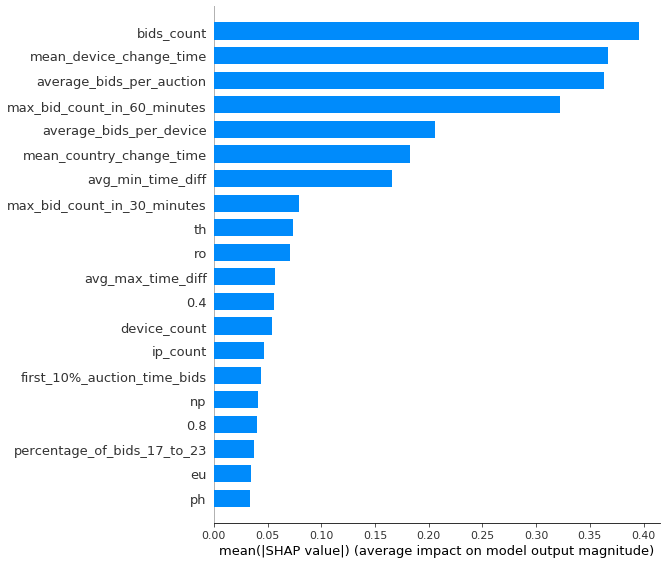

In [0]:
#SHAP
x_train.drop('outcome', axis=1, inplace=True)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type='bar')

In [0]:
def shap_plot(S,model,j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [0]:
shap.initjs()
S = x_test[y_test != wrong_xgb]
shap_plot(S, xgb_model, 0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
#kernelExplainer
rf_shap_values = shap.KernelExplainer(rf.predict ,wrong_rf)

Using 502 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [0]:
wrong_rf.astype('float64')

In [0]:
#shap.summary_plot(rf_shap_values.shap_values(wrong_rf.astype('float64')), wrong_rf.astype('float64'))

# IMPORTANT FEATURES

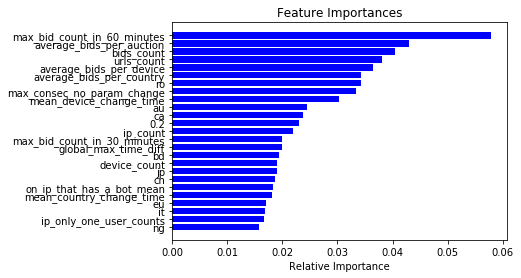

In [0]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)
features = x_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices[len(indices)-25:len(indices)])), importances[indices[len(indices)-25:len(indices)]], color='b', align='center')
plt.yticks(range(len(indices[len(indices)-25:len(indices)])), [features[i] for i in indices[len(indices)-25:len(indices)]])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
important_features = features[indices[len(indices)-50:len(indices)]]

In [0]:
values = importances[indices[len(indices)-50:len(indices)]]
sum(values)

0.9288234054110944

In [0]:
xgb_error_features = (x_test[xgb_pred != y_test])[important_features]
xgb_error_features

,bids_per_auction_per_ip_mean,hk,qa,th,id,address_rare_address,de,0.4,sg,percentage_of_bids_17_to_23,tr,last_10%_auction_time_bids,no,be,average_bids_per_url,cz,percentage_of_bids_5_to_11,first_10%_auction_time_bids,in,ch,mean_consec_no_param_change,0.9,avg_max_time_diff,np,py,ng,ip_only_one_user_counts,it,eu,mean_country_change_time,on_ip_that_has_a_bot_mean,cn,jp,device_count,bd,global_max_time_diff,max_bid_count_in_30_minutes,ip_count,0.2,ca,au,mean_device_change_time,max_consec_no_param_change,ro,average_bids_per_country,average_bids_per_device,urls_count,bids_count,average_bids_per_auction,max_bid_count_in_60_minutes
306,1.031348,0.010101,0.010101,0.060606,0.010101,1,0.040404,2.0,0.030303,21.884498,0.030303,19.0,0.010101,0.000000,29.909091,0.000000,0.000000,7.0,0.060606,0.000000,0.000000,0.0,5662.418072,0.000000,0.000000,0.101010,0.369732,0.000000,0.000000,40.0,0.290657,0.000000,0.010101,87,0.000000,78878.304314,117.0,289,220.0,0.191919,0.000000,302.0,0.0,0.010101,8.225000,3.781609,11,329,3.391753,191.0
162,1.540050,0.023061,0.004193,0.111111,0.111111,0,0.180294,36.0,0.012579,32.188420,0.180294,629.0,0.002096,0.010482,339.666667,0.058700,22.440301,942.0,1.000000,0.056604,2.167630,327.0,323224.863389,0.008386,0.000000,0.144654,0.360326,0.238994,0.136268,374.0,0.255061,0.000000,0.000000,147,0.002096,950997.668972,57.0,1482,808.0,0.111111,0.041929,368.0,12.0,0.236897,36.831325,20.795918,9,3057,8.375342,83.0
861,1.787461,0.009073,0.001008,0.001008,0.573589,1,0.024194,361.0,0.000000,27.962999,0.022177,712.0,0.007560,0.000504,4.551754,0.000504,23.742532,697.0,0.256552,0.000000,1.035533,622.0,48303.186355,0.002016,0.000504,1.000000,0.103954,0.000000,0.005544,67.0,0.536145,0.003024,0.000000,425,0.004032,1157.004464,92.0,1494,398.0,0.016129,0.000504,53.0,2.0,0.000000,73.084507,12.209412,1140,5189,20.673307,171.0
137,1.254937,0.000000,0.008354,0.004967,0.047415,1,0.005193,591.0,0.001580,37.056989,0.049221,1085.0,0.000677,0.000000,1.666430,0.001355,24.950383,980.0,1.000000,0.000000,1.373626,662.0,63978.404584,0.000452,0.001806,0.006774,0.357384,0.005193,0.000452,65.0,0.157448,0.000000,0.000452,451,0.001129,510.001968,129.0,3887,511.0,0.000452,0.006999,38.0,7.0,0.002484,92.815789,15.640798,4233,7054,12.802178,233.0
8,1.001085,0.000000,0.000000,0.000000,0.000000,1,0.000000,73.0,0.000000,0.000000,0.000000,74.0,0.000000,0.000000,923.000000,0.000000,55.796316,1.0,0.000000,0.000000,0.000000,383.0,48868.998062,0.000000,0.000000,0.000000,0.496454,0.000000,0.000000,1330.0,0.000000,0.000000,0.000000,124,0.000000,88762.342447,95.0,915,15.0,0.000000,0.000000,186.0,0.0,0.000000,923.000000,7.443548,1,923,16.781818,158.0
132,1.043646,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.089812,0.000000,60.885609,11.0,0.000000,0.351667,1.000000,0.0,54916.267424,0.000000,0.000000,0.000000,0.485117,0.000000,0.000000,34274.0,0.042362,0.000000,0.000000,3,0.000000,95664.369075,294.0,779,506.0,0.000000,0.000000,51411.0,1.0,0.000000,271.000000,271.000000,746,813,42.789474,449.0
1538,1.240482,0.015422,0.002537,0.041527,0.052876,1,0.305241,3415.0,0.030066,28.797357,0.027885,58164.0,0.006432,0.007233,716.526549,0.007789,22.630068,29186.0,0.698053,0.029487,1.022654,30521.0,230835.724181,0.002403,0.000601,0.000912,0.419912,0.030978,0.020430,6.0,0.041477,0.039012,0.019539,1144,0.002337,950404.666685,1141.0,111918,24227.0,0.021587,0.052231,5.0,2.0,0.018493,909.747191,141.551573,226,161935,194.867629,2231.0
1499,1.527871,0.000000,0.000000,0.000000,0.000000,0,0.000000,1.0,0.000000,30.417582,0.000000,434.0,0.000000,0.000000,3.013245,0.000000,17.450549,816.0,0.000000,0.000000,1.078947,205.0,469291.410538,0.000000,0.000000,0.000000,0.395911,0.000000,0.000000,1330.0,0.024259,0.000000,0.000000,249,0.000000,951669.671565,36.0,1484,804.0,0.000000,0.000000,426.0,3.0,0.000000,2275.000000,9.136546,755,2275,325.000000,62.0
378,2.016760,0.000000,0.000000,0.000000,0.953757,0,1.000000,19.0,0.005780,10.803324,0.011561,37.0,0.000000

In [0]:
bots_mean

address_infrequent_address               0.109589
address_rare_address                     0.616438
payment_account_infrequent_account       0.109589
payment_account_rare_account             0.410959
bids_count                            2899.054795
                                         ...     
percentage_of_bids_11_to_17             28.799723
percentage_of_bids_17_to_23             28.867940
percentage_of_bids_23_to_5              19.280964
percentage_of_bids_5_to_11              23.051374
outcome                                  1.000000
Name: mean, Length: 263, dtype: float64

In [0]:
important_bots_mean = bots_mean[important_features]
important_humans_mean = human_mean[important_features]

In [0]:
#histogram of bots vs humans
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        

def plot_histogram(names, bots_vals, humans_vals):
  x = np.arange(len(names))
  width = 0.8
  fig , ax = plt.subplots()
  rects1 = ax.barh(x - width/2, bots_vals.values.tolist(), width, label='Bots', align='center')
  rects2 = ax.barh(x + width/2, humans_vals.values.tolist(), width, label='Humans', align='center')
  fig.set_size_inches(15, 10)
  
  ax.set_ylabel('Scores')
  ax.set_title('Scores by group')
  ax.set_yticks(x)
  ax.set_yticklabels(names)
  ax.legend()



  autolabel(rects1, ax)
  autolabel(rects2, ax)
  fig.tight_layout()
  plt.show()
  return fig


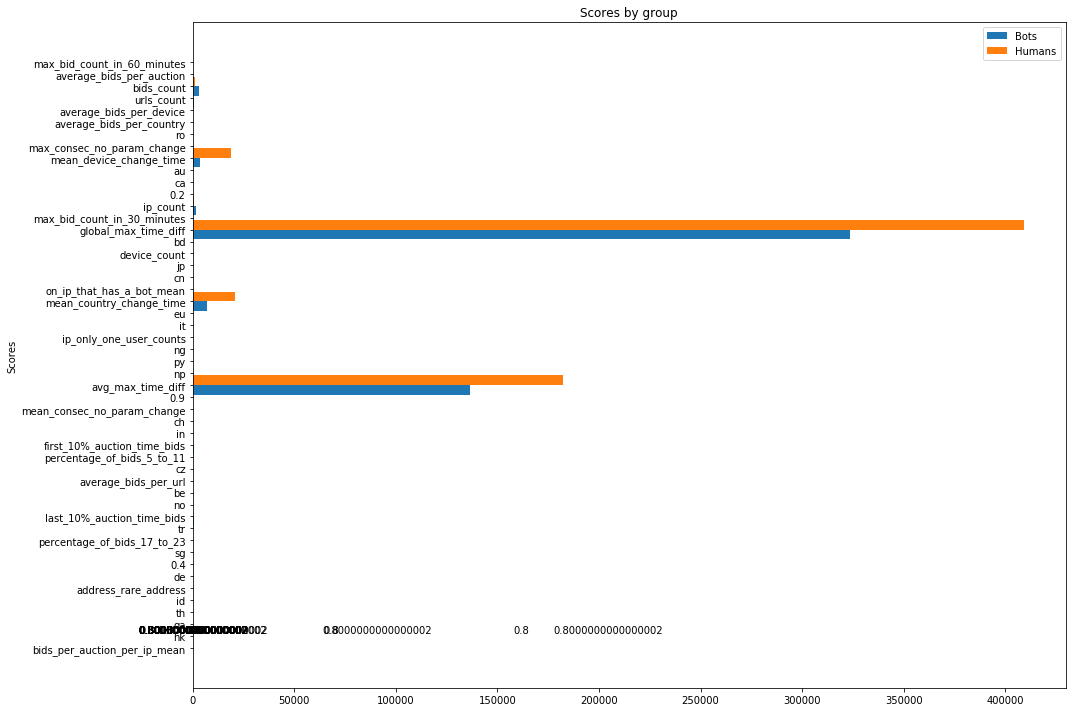

In [0]:
fig = plot_histogram(important_features, important_bots_mean, important_humans_mean)


In [0]:
normalized_bots_mean = important_bots_mean / np.linalg.norm(important_bots_mean)
normalized_humans_mean = important_humans_mean / np.linalg.norm(important_humans_mean)
normalized_xgb = (xgb_error_features.transpose() / np.linalg.norm(xgb_error_features, axis=1)).transpose()

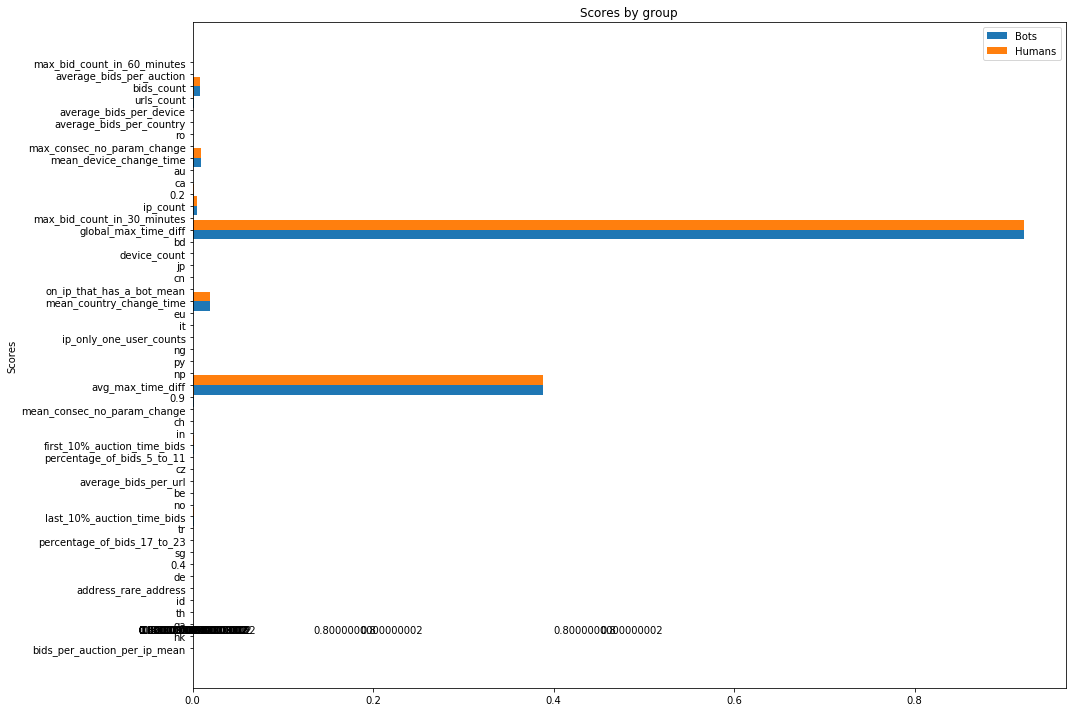

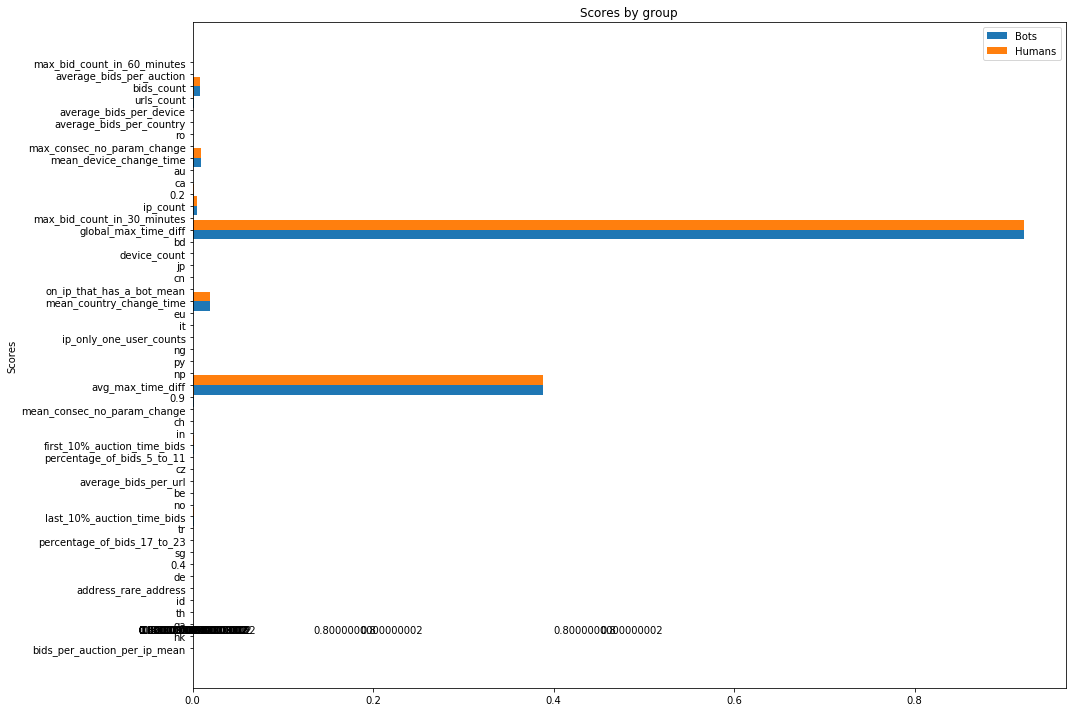

In [0]:
plot_histogram(important_features, normalized_bots_mean, normalized_bots_mean)

Nearest Neighbors of the bots that the model failed on



## Nearest Neighbors

In [0]:
#K nearest neighbors
important_x_train = x_train[important_features]
knn = NearestNeighbors(n_neighbors=5, algorithm='brute').fit(important_x_train)
index_lst = knn.kneighbors(xgb_error_features, return_distance=False)
for i in index_lst:
  print(y_train.iloc[i])

721     1.0
1518    0.0
1404    0.0
1353    1.0
1644    1.0
Name: outcome, dtype: float64
1517    1.0
1117    0.0
1788    0.0
1473    0.0
282     0.0
Name: outcome, dtype: float64
1615    0.0
1760    0.0
1926    0.0
732     0.0
176     1.0
Name: outcome, dtype: float64
991     0.0
849     0.0
1636    1.0
1968    0.0
976     0.0
Name: outcome, dtype: float64
1933    0.0
322     0.0
1997    0.0
1914    0.0
1174    0.0
Name: outcome, dtype: float64
1710    0.0
1578    0.0
1439    0.0
1660    0.0
119     0.0
Name: outcome, dtype: float64
321     0.0
121     0.0
469     0.0
1992    1.0
444     0.0
Name: outcome, dtype: float64
1738    0.0
1574    0.0
243     0.0
652     0.0
1079    0.0
Name: outcome, dtype: float64
582     0.0
1454    0.0
1196    1.0
1747    0.0
1691    0.0
Name: outcome, dtype: float64
732     0.0
1502    0.0
876     0.0
620     1.0
176     1.0
Name: outcome, dtype: float64
1926    0.0
1615    0.0
732     0.0
876     0.0
176     1.0
Name: outcome, dtype: float64
1368    1.

# Over Sampling (not SMOTE)

In [0]:
x_resampled, y_resampled = ROS().fit_resample(x_train, y_train)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [0]:
x_resampled_df = pd.DataFrame(x_resampled, columns=x_train.columns )
y_resampled_df = pd.DataFrame(y_resampled, columns=['outcome'])

In [0]:
x_resampled_df.head()

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
0,False,0,1,0,1,2,2,1,2,2,2,2,1,1,1,1,1,0.333333,1,0.5,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,30378.9,84018.3,94034.4,94034.4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,7634,7634,7634,7634,7634,7634,0,0,0,100
1,False,0,0,0,1,6,5,1,5,2,5,1,1.2,1.2,6,3,1,0.4,1,0.4,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,21486.1,21486.1,379.001,34559.1,0,1,2,1,1,0,0,1,0,0,0,0,0,0,0,0,2,2,2,1,1,28212,20828,20828,21865,379,379,33.3333,0,33.3333,33.3333
2,False,0,1,0,1,2,2,1,2,2,2,2,1,1,1,1,1,0.333333,1,0.5,1,1,1,1,1,0.5,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0.5,30378.9,84018.3,1.41766e+06,1.41766e+06,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,35255,35255,35255,35255,35255,35255,50,0,0,50
3,False,0,1,0,0,2,2,1,2,2,2,2,1,1,1,1,1,0.333333,1,0.5,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,30378.9,84018.3,84038.3,84038.3,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,0,0,84038,84038,84038,84038,84038,84038,0,100,0,0
4,False,0,0,0,0,155,23,1,53,2,123,91,6.73913,2.92453,1.7033,77.5,1.20155,0.359504,1,0.260163,1,1,1,1,1,0.010989,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,7,78,0.503226,17576.2,70173.4,1,30765.1,78,25,16,4,1,3,13,4,4,7,0,0,0,0,0,0,8,15,23,7,2.90909,50994,1764,1591,5352,1,1,9.67742,47.0968,4.51613,38.7097


In [0]:
x_resampled_df.shape

(2866, 263)

In [0]:
y_resampled_df.sum()

outcome    1433.0
dtype: float64

In [0]:
x_resampled_df = x_resampled_df.astype('float')

In [0]:
#fit models and predict
xgb_model.fit(x_resampled_df, y_resampled)
xgbrf_model.fit(x_resampled_df, y_resampled)
rf.fit(x_resampled_df, y_resampled)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight={0: 1,
                                                                       1.0: 20},
                                                         criterion='gini',
                                                         max_depth=8,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                      

In [0]:
#predict classification
xgb_resampled_pred = xgb_model.predict(x_test)
xgbrf_resampled_pred = xgbrf_model.predict(x_test)
rf_resampled_pred = rf.predict(x_test)

#models average precision score on test
print('xgb: ' + str(average_precision_score(y_test, xgb_resampled_pred)))
print('xgbrf: ' + str(average_precision_score(y_test,xgbrf_resampled_pred )))
print('RF_Ada: ' + str(average_precision_score(y_test, rf_resampled_pred)))

xgb: 0.21791235059760958
xgbrf: 0.26189370178859034
RF_Ada: 0.19299724180202266


In [0]:
(y_test[y_test != xgb_resampled_pred])

1966    0.0
1133    0.0
1685    0.0
1447    0.0
162     1.0
671     0.0
1765    0.0
919     0.0
1051    0.0
1906    0.0
861     1.0
29      0.0
666     0.0
1538    1.0
1499    1.0
1999    1.0
258     0.0
138     0.0
1302    0.0
827     0.0
1009    0.0
276     0.0
1794    0.0
1481    0.0
1480    1.0
1335    0.0
935     1.0
723     1.0
1265    1.0
995     0.0
1565    0.0
803     0.0
1223    0.0
1706    1.0
1863    0.0
288     1.0
448     0.0
Name: outcome, dtype: float64

In [0]:
#lets try to predict probabilities
xgb_resampled_pred = xgb_model.predict_proba(x_test)[:,1]
xgbrf_resampled_pred = xgbrf_model.predict_proba(x_test)[:,1]
rf_resampled_pred = rf.predict_proba(x_test)[:,1]

#models average precision score on test
print('xgb: ' + str(average_precision_score(y_test, xgb_resampled_pred)))
print('xgbrf: ' + str(average_precision_score(y_test,xgbrf_resampled_pred )))
print('RF_Ada: ' + str(average_precision_score(y_test, rf_resampled_pred)))

xgb: 0.6111734234138996
xgbrf: 0.4676392073180435
RF_Ada: 0.4404515566613304


In [0]:
xgb_train_pred = xgb_model.predict(x_train)
xgbrf_train_pred = xgbrf_model.predict(x_train)
rf_train_pred = rf.predict(x_train)

#models average precision score on train
print('xgb: ' + str(average_precision_score(y_train, xgb_train_pred)))
print('xgbrf: ' + str(average_precision_score(y_train,xgbrf_train_pred )))
print('RF_Ada: ' + str(average_precision_score(y_train, rf_train_pred)))

xgb: 0.6083333333333333
xgbrf: 0.4965986394557823
RF_Ada: 0.5748031496062992


In [0]:
xgb_train_pred = xgb_model.predict_proba(x_train)[:,1]
xgbrf_train_pred = xgbrf_model.predict_proba(x_train)[:,1]
rf_train_pred = rf.predict_proba(x_train)[:,1]

#models average precision score on train
print('xgb: ' + str(average_precision_score(y_train, xgb_train_pred)))
print('xgbrf: ' + str(average_precision_score(y_train,xgbrf_train_pred )))
print('RF_Ada: ' + str(average_precision_score(y_train, rf_train_pred)))

xgb: 0.9973436050376538
xgbrf: 0.9690894848522891
RF_Ada: 1.0


In [0]:
bestClf.fit(x_resampled_df, y_resampled)
best_Clf_pred = bestClf.predict(x_test)
print('best_Clf classification: ' + str(average_precision_score(y_test, best_Clf_pred)))
best_Clf_proba = bestClf.predict_proba(x_test)[:,1]
print('best_Clf classification: ' + str(average_precision_score(y_test, best_Clf_proba)))

best_Clf classification: 0.18579713931160602
best_Clf classification: 0.38670413050220354


Prediction

In [0]:
test_path = drive_dir + "all_features_test.csv"
X_test = pd.read_csv(test_path)

In [0]:
X_test.head()

,Unnamed: 0,bidder_id,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
0,0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,False,0,1,0,0,4,3,1,2,3,4,3,1.333333,2.000000,1.333333,1.333333,1.000000,0.000000,1,0.500000,1,1.000000,1,1.0,1,0.333333,1.0,1.333333,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0,1.0,2.0,0.500000,4.545421e+12,4.545421e+12,4.545421e+12,5.989721e+13,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,70350.0,23440.0,70350.0,86363.0,23440.0,86363.0,50.000000,0.000000,25.000000,25.000000
1,1,a921612b85a1494456e74c09393ccb65ylp4y,True,0,0,0,0,3,2,1,3,2,2,1,1.500000,1.000000,3.000000,1.500000,1.500000,0.500000,0,0.000000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0,1.0,2.0,0.666667,1.052632e+08,1.052632e+08,1.052632e+08,7.600195e+13,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.000000,61639.0,74019.0,61639.0,61639.0,2.0,61639.0,33.333333,66.666667,0.000000,0.000000
2,2,6b601e72a4d264dab9ace9d7b229b47479v6i,False,0,0,0,1,17,14,1,4,3,4,2,1.214286,4.250000,8.500000,5.666667,1.133333,0.150000,1,0.250000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0,5.0,2.0,0.117647,9.542105e+10,9.542105e+10,2.631579e+08,2.485789e+11,2.0,0.0,0.0,3.0,0.0,2.0,4.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,16.0,16.0,3.0,1.555556,1843.0,921.0,1843.0,261.0,20.0,261.0,0.000000,100.000000,0.000000,0.000000
3,3,eaf0ed0afc9689779417274b4791726cn5udi,False,1,0,0,0,148,90,1,81,14,129,80,1.644444,1.827160,1.850000,10.571429,1.072464,0.225131,1,0.310078,1,1.000000,1,1.0,1,0.012500,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0,30.0,43.0,0.290541,1.363488e+13,1.750337e+13,2.105263e+08,5.015947e+13,43.0,22.0,4.0,8.0,2.0,5.0,6.0,9.0,19.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0,7.0,1.0,1.000000,8753.0,6336.0,6108.0,33.0,4.0,4.0,18.918919,43.918919,17.567568,19.594595
4,4,cdecd8d02ed8c6037e38042c7745f688mx5sf,False,0,1,0,0,23,20,1,17,2,17,1,1.150000,1.352941,23.000000,11.500000,1.000000,0.378378,1,0.176471,1,0.941176,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,...,0.0,0,1.0,10.0,0.434783,2.162930e+12,2.162930e+12,6.421053e+09,3.373105e+12,10.0,6.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0,13.0,0.0,0.000000,29907.0,5678.0,5678.0,26120.0,122.0,122.0,13.043478,0.000000,82.608696,4.347826


In [0]:
bidder_id = X_test['bidder_id']
X_test.drop(['Unnamed: 0', 'bidder_id'], axis=1, inplace=True)
X_test['global_max_time_diff'] = X_test['global_max_time_diff'] / 52631375.8934375
X_test['avg_max_time_diff'] = X_test['avg_max_time_diff'] / 52631375.8934375
X_test['avg_min_time_diff'] = X_test['avg_min_time_diff'] / 52631375.8934375
X_test['global_min_time_diff'] = X_test['global_min_time_diff'] / 52631375.8934375

In [0]:
rf_best = RF(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0.0: 1, 1.0: 20}, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
rf_best = AdaB(base_estimator=rf, n_estimators=500)

In [0]:
xgb_best = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=16,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
rf_best.fit(X, Y)
xgb_best.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=16,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
rf_best_pred = rf_best.predict_proba(X_test)[:,1]
xgb_best_pred = xgb_best.predict_proba(X_test)[:,1]

In [0]:
submission_rf = pd.concat([bidder_id ,pd.Series(rf_best_pred)] , axis=1 )
submission_xgb = pd.concat([bidder_id ,pd.Series(xgb_best_pred)] , axis=1 )

In [0]:
submission_rf.rename({0: 'prediction'}, axis=1, inplace=True)
submission_xgb.rename({0: 'prediction'}, axis=1, inplace=True)

In [0]:
submissions_folder_path = '/content/drive/Shared drives/DS Workshop/data/Submissions'
submission_rf.to_csv(path_or_buf=submissions_folder_path + '/29.2_sub_Ada.csv', index=False)